In [1]:
import numpy as np
from scipy.special import erfc
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# --- funciones ---
def f_decision(x,w):	
	fmax_R = x[0]/Rmax
	fmin_ber=np.log(x[1])/np.log(Bermin)
	#fmin_ber=Bermin/x[1]
	#fmin_ber=np.log(Bermin/x[1])
	#fmin_ber=np.log(x[1]/Bermin)
	#fmin_P = Pmin/x[2]
	x=np.array([fmax_R,fmin_ber])
	return np.dot(x,w)
#------------------

In [3]:
er=6370 # Radio de la tierra en Km
h=800   # Altura de la órbita en Km
r=er+h    # Distancia del satélite al centro de la tierra 

po=100    #Período orbital en minutos
timestep=9.2 # paso de actualización en segundos
GS=np.array([0,er])# Coordenadas de la "Ground Station"


w0=0.33  # peso del bitrate
w1=1-w0  # peso del ber

at=4 # n° de acciones
alpha =.5
ep=1/at
gamma=0.9

In [4]:
k=16973 # cte : PIRE + G/T ver link budget
dmax=3000 # [km]
dmin=800  # [km]
steps=115    # steps

angmax=np.arccos(er/r) # Ángulo en el horizonte
xmax=r*np.sin(angmax)  # Coordenada x en el horizonte ,y=0
dt=(2*np.pi/(po*60))*timestep # Delta ángulo [Rad]

angle=np.arange(-angmax,angmax+dt,dt)
x=r*np.sin(angle) # Coordenada x cada timestep
y=r*np.cos(angle) # Coordenada y cada timestep

d=np.sqrt(x**2+(y-er)**2) # distancia satélite-GS

In [5]:
st=len(d)

mt=np.zeros((st,at))
a=mt.T
# matriz de transición del estado i al j según la acción

col=np.arange(1,st+1)
a[:]=col
mt=a.T

In [6]:
steps= len(d)
m=4
arg=(k/d)*np.sin(np.pi/m)
ber0=norm.sf(arg)

m=8
arg=(k/d)*np.sin(np.pi/m)
ber1=norm.sf(arg)

m=16
arg=(k/d)*np.sin(np.pi/m)
ber2=norm.sf(arg)

m=32
arg=(k/d)*np.sin(np.pi/m)
ber3=norm.sf(arg)


In [7]:
# ber en una arreglo
ba=np.vstack((ber0,ber1,ber2,ber3))
Bermin=min(ber0)
Rmax=4   # accion = m ,1Msb/s para m=4 => R=2 Mb/s
R=np.array([1,2,3,4]) # bit rate ver ITU Bandwith 

In [8]:
w0=.33
w1=1-w0
w=np.array([w0,w1])

w0=0.2
w1=1-w0
w=np.array([w0,w1])

rv=np.zeros((steps,at)) # rewards
for n in range(steps):
    for a in range(at):
        baux=ba[a][n]
        #print(ba[a][n],a,n)
        if baux <= Bermin:
            baux=Bermin
        rv[n][a]=1/f_decision([R[a],baux],w)
        #print(R[a]/Rmax/2 + Bermin/baux/2)
pol=np.amax(rv,axis=1)

In [9]:
rv1=np.array([1 if e<1e-4 else 0 for row in ba for e in row ]).reshape(ba.shape)
rv1=(rv1*R.reshape(4,1)).T
pol=np.amax(rv1,axis=1)

In [10]:
# cálculo exacto de q*(s,a)
Qmax = np.zeros((st+1,at))
Qmax[st-1]=rv1[st-1]
for i in range(st-2,-1,-1):
	Qmax[i]=rv1[i]+gamma*np.amax(Qmax[i+1])

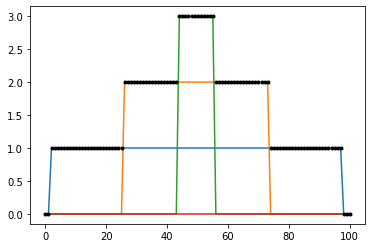

In [11]:
plt.plot(rv1)
plt.plot(pol,'k.')

##### 

In [12]:
r1=np.zeros((steps,at)) # rewards objetive 1
r2=np.zeros((steps,at)) # rewards objetive 2

for n in range(steps):
    for a in range(at):
        baux=ba[a][n]
        #print(ba[a][n],a,n)
        if baux <= Bermin:
            baux=Bermin
        r1[n][a]=f_decision([R[a],baux],[1,0])
        r2[n][a]=f_decision([R[a],baux],[0,1])
        #print(R[a]/Rmax/2 + Bermin/baux/2)
pol1=np.amax(rv,axis=1)
pol2=np.amax(rv,axis=1)

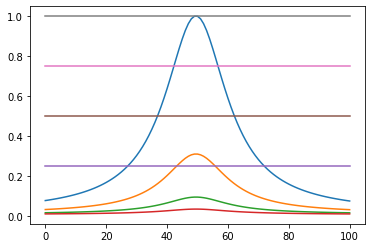

In [13]:
plt.plot(r2)
plt.plot(r1)

In [14]:
gamma

0.9

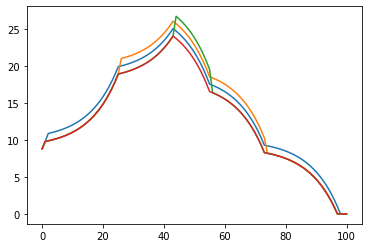

In [15]:
plt.plot(Qmax[:-1])

In [16]:
# cálculo exacto de q*(s,a) para cada objetivo por separado
Qmax1 = np.zeros((st+1,at))
Qmax2 = np.zeros((st+1,at))

Qmax1[st-1]=r1[st-1]
Qmax2[st-1]=r2[st-1]
#print("Qmax[",st-1,"]",Qmax[st-1])
for i in range(st-2,-1,-1):
    Qmax1[i]=r1[i]+gamma*np.amax(Qmax1[i+1])
    Qmax2[i]=r2[i]+gamma*np.amax(Qmax2[i+1])
#	print("Qmax[",i,"]",Qmax[i],"amax Qmax",np.amax(Qmax[i+1]))
#--

0.9


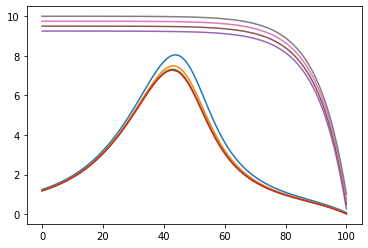

In [17]:
print(gamma)

plt.plot(Qmax2[:-1])
plt.plot(Qmax1[:-1])

In [18]:
# Linear scalarisation function
def f(v,w):
    return 1/np.dot(v,w)
    

In [19]:
# Epsilon greedy action selection
def e_greedy(qsa):
    z=np.random.uniform(0,1,1)
    if z > ep:
        res = np.where(qsa == max(qsa))
        a=np.random.choice(res[0]) # acción al azar si hay acciones con la misma Qmax(s,a) 
        ac2='Qmax'
    else:
        res = np.where(qsa != max(qsa))
        if res[0].size == 0:
            a=np.random.choice(range(len(qsa))) # en el caso de que todos lo Q(s,a) sean iguales a Qmax(s,a)
        else:
            a=np.random.choice(res[0]) # acción al azar entre las Q(s,a) < Qmax(s,a)
        ac2='Expl'
    return a
    
    

In [20]:
def ScalarisedActionSelection(s,Q1,Q2,w):
    ScalarisedQList=np.array([])
    for a in range(at):
        v= [Q1[s, a], Q2[s, a]]
      #  print(v)
        ScalarisedQ=f(v,w)
        #print(ScalarisedQ)
        ScalarisedQList=np.append(ScalarisedQList,ScalarisedQ)
        #print(scalarisedQList)
    return e_greedy(ScalarisedQList) 

In [21]:
def mse(x,y):
    return ((x-y)**2).mean()

In [31]:
# Q-Learning
np.random.seed(1)
Q = np.zeros((st+1,at))# el más uno es por que le estoy sumando un estado final 
Q1= np.random.randn(st+1,at)
Q2= np.random.randn(st+1,at)
Q1[st]=0
Q2[st]=0

Gacc=np.array([])
racc=np.array([])
aacc=np.array([])
N=1000
for e in range(N):
	G=0
	ep=0.1
#	if e>400:
#		ep=0.01
	j=0 # j= estado inicial 

	for n in range(steps):
		i=j
		#uj=ScalarisedActionSelection(j,Q1,Q2,w) # elijo la acción e-greedy
		uj=e_greedy(Q[j])
		ui=uj

		j= int(mt[i,ui])     # j next state ,j must be integer if it is used as index
		# paso 2	
		Q[i,ui]=Q[i,ui]+alpha*(rv1[n][ui] + gamma*max(Q[j])-Q[i,ui]) 
		Q1[i,ui]=Q1[i,ui]+alpha*(r1[n][ui] + gamma*max(Q1[j])-Q1[i,ui]) 
		Q2[i,ui]=Q2[i,ui]+alpha*(r2[n][ui] + gamma*max(Q2[j])-Q2[i,ui]) 
		G+=rv1[n][ui]# suma de los rewards
		racc=np.append(racc, rv[n][ui])
		aacc=np.append(aacc, ui)
	Gacc=np.append(Gacc, G)
#	print("Retornos por episodios de",steps,"pasos Retorno=","{0:0.2f}".format(G),"{0:0.2f}".format(100*G/np.sum(pol)),'%')

print()
# print("q*(s,a)\n",Qmax[:-1])
print("Máximo retorno computado","{0:0.2f}".format(np.sum(pol)))
print('ep=',ep)
#print('w=',w)
print("Retorno medio",np.mean(100*Gacc/np.sum(pol)))


Máximo retorno computado 156.00
ep= 0.1
Retorno medio 87.01410256410256


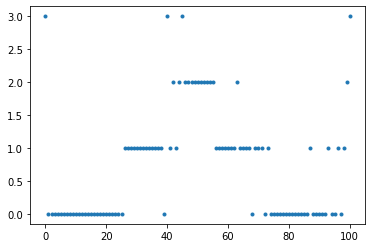

In [43]:
91.02628205128207
90.86346153846154
n=800
plt.plot(aacc[st*(n-1):st*n],'.')

MSE(Qmax,Q)= 1.444386e-10


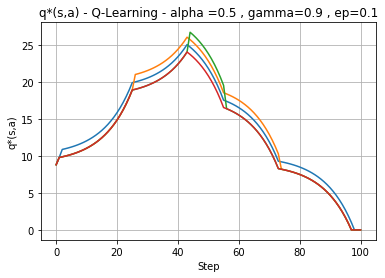

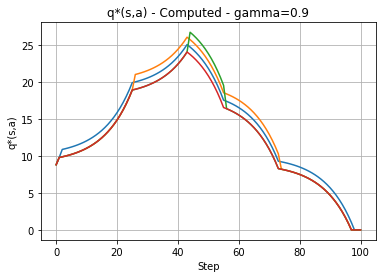

In [37]:

fig=plt.figure()
plt.title('q*(s,a) - Q-Learning - alpha ='+str(alpha)+' , gamma='+str(gamma)+' , ep='+str(ep))
plt.grid(True)
#plt.legend((' '))
plt.xlabel('Step')
plt.ylabel('q*(s,a)')
plt.plot(Q[:-1])

fig=plt.figure()
plt.title('q*(s,a) - Computed - gamma='+str(gamma))
plt.grid(True)
#plt.legend((' '))
plt.xlabel('Step')
plt.ylabel('q*(s,a)')
plt.plot(Qmax[:-1])

'''
fig=plt.figure()
plt.title('q1*(s,a) - Q-Learning - alpha ='+str(alpha)+' , gamma='+str(gamma)+' , ep='+str(ep)+ ' [w0 w1] = [' + str(w0)+' '+str(w1)+']')
plt.grid(True)
#plt.legend((' '))
plt.xlabel('Step')
plt.ylabel('q*(s,a)')

plt.plot(Q1[:-1])

fig=plt.figure()
plt.title('q2*(s,a) - Q-Learning - alpha ='+str(alpha)+' , gamma='+str(gamma)+' , ep='+str(ep)+ ' [w0 w1] = [' + str(w0)+' '+str(w1)+']')
plt.grid(True)
#plt.legend((' '))
plt.xlabel('Step')
plt.ylabel('q*(s,a)')

plt.plot(Q2[:-1])

fig=plt.figure()
plt.title('q*(s,a) - Q-Learning - alpha ='+str(alpha)+' , gamma='+str(gamma)+' , ep='+str(ep)+ ' [w0 w1] = [' + str(w0)+' '+str(w1)+']')
plt.title('[Q1 Q2].[w0 w1]   '+ ' [w0 w1] = [' + str(w0)+' '+str(w1)+']')
plt.grid(True)
#plt.legend((' '))
plt.xlabel('Step')
plt.ylabel('q*(s,a)')

plt.plot(1/(Q1[:-1]*w0+Q2[:-1]*w1))
'''
print('MSE(Qmax,Q)=',"{:e}".format(mse(Qmax,Q)))
#print('MSE(Qmax,[Q1 Q2].[w0 w1])=',"{:e}".format(mse(Qmax[:-1],1/(Q1[:-1]*w0+Q2[:-1]*w1))))


In [38]:
mse(Qmax,Q)

1.4443863408462207e-10

In [26]:
len(Q)

102

In [41]:
100*np.mean(Gacc[800:])/np.sum(pol)

91.75

0.9175

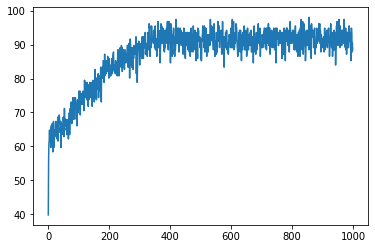

In [42]:
plt.plot(100*Gacc[0:]/np.sum(pol))

In [26]:
len(Gacc)

1000